In [1]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.cm as cm
cmap = cm.tab10


In [2]:
## custom packages
src_dir = os.path.join(os.pardir,'src')
sys.path[0] = src_dir

from data_io_ts import *
from stats import xdata_to_xnx, x_autocorr_sm_ext
from stretchedexponential_fit import *

# import setup for figure layout (see src/modules_plotting.py to customize)
from modules_plotting import * 


# Get a dataset:

Sequence of interevent times x (measured in words) of consecutive occurrences of the word “the” in the book “Moby Dick” obtained from Project Gutenberg.
We select a minimum interevent time of $x_{\min}=3$

It has been proposed that the distribution follows a stretched exponential, i.e. its cumulative distribution is 

$F(x) \propto e^{-\alpha x^{-\beta}}$

In [3]:
label = 'interevent_pg'

dict_args =  {
    'pg_number': 2701,
    'w': 'the',
    'xmin': 3,
    'src_dir':src_dir,
    }

x_data = get_xdata_ts_wrapper(label,dict_args)
N = len(x_data)

# Plot the distribution and the fit

Note that we are plotting the cumulative distribution $F(x)$.

In [4]:
## Empirical distribution
xmin = 3
xmax = None
x,nx = xdata_to_xnx(x_data,norm=False,xmin=xmin,xmax=xmax)

N = np.sum(nx)
px = nx/N
Fx = 1-np.cumsum(px)

## Fit: stretched exponential

result = fit_se_disc(x,nx,xmin=xmin)
a_fit = result[0][0]
b_fit = result[0][1]
px_fit = Px_se_disc(x,a_fit,b_fit,xmin=xmin)
Fx_fit = 1.-cdf_se_disc(x,a_fit,b_fit,xmin=xmin)

Text(0.6,0.8,'$\\propto e^{-\\alpha x^{\\beta}}$')

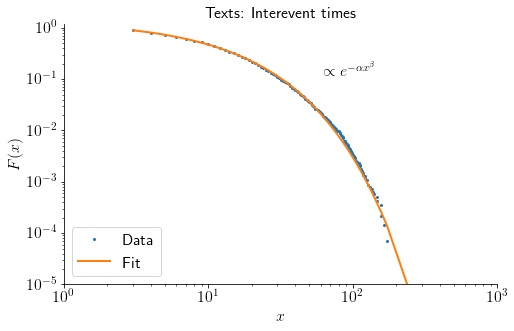

In [5]:
fig, ax = plt.subplots(nrows=1, ncols=1)#, figsize=fig_size)

## Plot the distribution
x_ = x
y_ = Fx

c_ = cmap(0)
ax.plot(x_,y_,marker='o',ms=2,lw=0,c = c_,label = 'Data')

## Plot the fit
c_ = cmap(1)
x_ = x
y_ = Fx_fit
plt.plot(x_,y_,lw=2,c=c_, label = 'Fit')


## Layout stuff
ax.legend(loc='lower left')

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlim(1,1000)
ax.set_ylim(10**(-5),1.2)

ax.set_xlabel(r'$x$')#,labelpad=0)
ax.set_ylabel(r'$F(x)$')
ax.set_title('Texts: Interevent times')

x_annot_formula = 0.6
y_annot_formula = 0.8
ax.annotate(r'$\propto e^{-\alpha x^{\beta}}$',xy=(x_annot_formula,y_annot_formula),xycoords = 'axes fraction')#,size=8)

# Autocorrelation function

In [6]:
np.random.seed(42)

nrep = 10**3
q1,q2 = 1,99
result = x_autocorr_sm_ext(x_data,nrep=nrep,q=[q1,q2])
x = result['tau']
y_mu,y_1,y_2 = result['C']
y_mu_rand,y_1_rand,y_2_rand = result['C_rand']

## here we calculate from t=0,1,...,t^* where t^* is the first point
## where true C(t) is within the q-percentiles of the random

# ind_t_star = np.where( (y_mu<=y_2_rand)&(y_mu>=y_1_rand) )[0][1]
ind_t_star = np.where(y_1<=y_2_rand)[0][2]
tau_star = x[ind_t_star]

print('Autocorrelation time: ',tau_star)



Autocorrelation time:  20


Text(0.8,0.6,'$\\tau^*=20$')

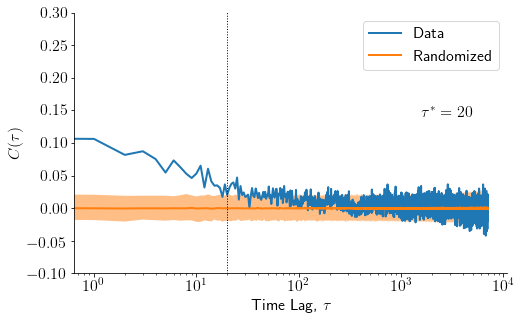

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=1)#, figsize=fig_size)

alpha_val = .5
## Plot the empirical autocorrelation
x_ = x
y_ = y_mu
z1_ = y_1
z2_ = y_2
c_ = cmap(0)
ax.plot(x_,y_,c = c_,lw=lw, label = 'Data')
ax.fill_between(x_,z1_,z2_,color=c_,alpha=alpha_val,lw=0)



## Plot the randomized autocorrelation
x_ = x
y_ = y_mu_rand
z1_ = y_1_rand
z2_ = y_2_rand
c_ = cmap(1)
ax.plot(x_,y_,c = c_,lw=lw, label = 'Randomized')
ax.fill_between(x_,z1_,z2_,color=c_,alpha=alpha_val,lw=0)


ax.plot([tau_star,tau_star],[-1,1],lw=1,color='black',ls=':')


## Layout stuff
ax.legend(loc='upper right')

ax.set_xscale('log')
# ax.set_yscale('log')

ax.set_xlabel(r'Time Lag, $\tau$')#,labelpad=0)
ax.set_ylabel(r'$C(\tau)$')
ax.set_ylim(-0.1,0.3)


x_annot_tau = 0.8
y_annot_tau = 0.6
ax.annotate(r'$\tau^*=%s$'%(int(tau_star)),xy=(x_annot_tau,y_annot_tau),xycoords = 'axes fraction')




# Subsampling the data

### p-value for the original dataset

In [8]:
nrep_synth = 100 ## number of synthetic datasets to generate for empirical p-value

x,nx = xdata_to_xnx(x_data,norm=False,xmin=xmin,xmax=xmax)

result = fit_se_disc_sign(x,nx,xmin=xmin, nrep_synth=nrep_synth)
alpha = result['a'] ## fitted parameter alpha
beta = result['b'] ## fitted parameter beta
pval = result['pval'] ## p-value
KS = result['KS'] ## KS-distance

print('Original dataset. N = %s'%(N))
print('Empirical p-value from %s synthetic datasets: '%(nrep_synth), pval)

Original dataset. N = 14042
Empirical p-value from 100 synthetic datasets:  0.050000000000000044


### p-value from subsampled dataset

Note that the subsampling generates different datasets each time; therefore there will be variability in the measured p-value

In [9]:
p_sub = 1./tau_star ## 0 ... 1 (keep nothing ... keep all); we set 1/tau_star
N_sub = int(p_sub*N)
nrep_synth = 100 ## number of synthetic datasets to generate for empirical p-value


## subsample -- take N_sub samples from x_data without replacement
x_data_sub = np.random.choice(x_data,size=N_sub,replace=False)
x,nx = xdata_to_xnx(x_data_sub,norm=False,xmin=xmin,xmax=xmax)
result = fit_se_disc_sign(x,nx,xmin=xmin, nrep_synth=nrep_synth)
alpha = result['a'] ## fitted parameter alpha
beta = result['b'] ## fitted parameter beta
pval = result['pval'] ## p-value
KS = result['KS'] ## KS-distance

print(r'Subsampled dataset: n = %s (n/N ~ %s)'%(N_sub,p_sub)) 
print('Empirical p-value from %s synthetic datasets: '%(nrep_synth), pval)

Subsampled dataset: n = 702 (n/N ~ 0.05)
Empirical p-value from 100 synthetic datasets:  0.44999999999999996
